# importing modules

In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.tri as tri
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from matplotlib.collections import LineCollection

# loading data

In [112]:
# Load data
data = pd.read_csv('thermoData.csv')

# fitting machine learning model

In [113]:
fit_what=5
fit_model='XGBoost'
if fit_what==7:
    label='Solidus $-~\\beta$ transus temperature [C]'
    clim=[600,1700]
elif fit_what==5:
    label='$\\beta$ transus temperature [C]'
    clim=[700,1200]
elif fit_what==6:
    label='$Solidus transus temperature [C]'
    clim=[1700,3000]

#X = data.iloc[:,]
X=np.array(data.iloc[:,1:5])
y=np.array(data.iloc[:,fit_what])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=10)

# Dictionary of models
models = {
    #'Linear Regression': LinearRegression(),
    #'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=1000)
}

models['XGBoost'] = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
#models['SVR'] = SVR(kernel='rbf', C=1.0, epsilon=0.1)
#models['Neural Network'] = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=500)

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions1 = model.predict(X_train)
    mse = mean_squared_error(y_test, predictions)
    mse1 = mean_squared_error(y_train, predictions1)
    results[name] = mse
    print(f'{name} MSE: {np.sqrt(mse1)}')

# Optionally, print the best model based on MSE
best_model = min(results, key=results.get)
print(f'Best performing model: {best_model} with MSE: {results[best_model]}')

Random Forest MSE: 13.945112516332086
XGBoost MSE: 23.893752058702027
Best performing model: Random Forest with MSE: 19.58805970557881


# defining supporting plotting functions

In [114]:
def get_contrasting_color(color):
    # Convert RGB to HSV
    hsv = rgb_to_hsv(color)
    # Adjust hue by 180 degrees (0.5 in [0, 1] scale) and invert value
    hsv[0] = (hsv[0] + 0.5) % 1.0
    hsv[2] = 1.0 - hsv[2]
    # Convert back to RGB
    return hsv_to_rgb(hsv)

# Function to convert ternary composition to Cartesian coordinates
def ternary_to_cartesian(A, B, C):
    x = 0.5 * (2 * B + C) / (A + B + C)
    y = np.sqrt(3) / 2 * C / (A + B + C)
    return x, y

# Heat values for each composition
values = np.array([0, 0, 0, 0.5, 0.5, 0.5, 1])

def generate_ternary_compositions(steps):
    """
    Generate a grid of ternary compositions with specified steps between points.
    """
    compositions = []
    for i in range(steps + 1):
        for j in range(steps + 1 - i):
            k = steps - i - j
            A = i / steps
            B = j / steps
            C = k / steps
            compositions.append([A, B, C])
    return np.array(compositions)

def calculateVEC(c,v1,v2,v3):
    chemSpecies=[v1,v2,v3]
    valenceElectrons=dict({\
        ('Cr',6), ('Ti',4), ('V',5), ('W',6), \
        ('Nb',5), ('Zr',4), ('Ta',5), ('Mo',6),\
        ('Al',3)\
        }) #valence electrons
    vec=[]
    for j, val in enumerate(c):
        sum=0
        for i, chem in enumerate(chemSpecies):
            sum += valenceElectrons[chem]*c[j,i]
        vec.append(sum)
    vec=np.array(vec)
    bsd=0.1914*vec-0.1089
    epsilon_p=-13706.12*bsd**3+38196.22*bsd**2-35519.70*bsd+11025.99
    return(epsilon_p)

def calculateVEC_rev1(c, v1, v2, v3):
    chemSpecies = [v1, v2, v3]
    valenceElectrons = {
        'Cr': 6, 'Ti': 4, 'V': 5, 'W': 6,
        'Nb': 5, 'Zr': 4, 'Ta': 5, 'Mo': 6,
        'Al': 3
    }  # valence electrons
    
    vec = []
    epsilon_p = []
    
    for j, val in enumerate(c):
        # Compute VEC
        vec_sum = 0
        for i, chem in enumerate(chemSpecies):
            vec_sum += valenceElectrons[chem] * c[j, i]
        vec.append(vec_sum)

        # Compute bsd
        bsd = 0.1914 * vec_sum - 0.1089

        epsilon_p_val = -13706.12 * bsd**3 + 38196.22 * bsd**2 - 35519.70 * bsd + 11025.99

        if ( epsilon_p_val > 2  and epsilon_p_val < 31.517 ):
            epsilon_p.append(epsilon_p_val)
        elif ( epsilon_p_val >= 31.517 ):
            epsilon_p.append(31.517)
        elif ( epsilon_p_val <=2 ):
            epsilon_p.append(2)
    
    return np.array(epsilon_p)

# main plotting function

In [115]:
# Function to plot the heatmap
def plot_ternary_heatmap(ax,v1,v2,v3,v4,Cr_fraction):

    # Define the number of steps between 0 and 1 (inclusive)
    steps = 200  # Smaller step size means more detailed grid

    compositions = generate_ternary_compositions(steps)
    xy = np.array([ternary_to_cartesian(*comp) for comp in compositions])
    triangulation = tri.Triangulation(xy[:, 0], xy[:, 1])

    scaled_compositions = compositions * (1-Cr_fraction)
    # Create the new column to add, making it n x 1
    Cr_column = np.ones((len(compositions),1)) * Cr_fraction
    new_compositions = np.hstack((scaled_compositions, Cr_column))*100

    reorderd_compositions = np.zeros(np.shape(new_compositions))

    reorderd_compositions[:,0] = new_compositions[:,3]
    reorderd_compositions[:,1] = new_compositions[:,2]
    reorderd_compositions[:,2] = new_compositions[:,0]
    reorderd_compositions[:,3] = new_compositions[:,1]

    print(new_compositions)

    #values = calculateVEC_rev1(new_compositions,v1,v2,v3,v4)
    
    for name, model in models.items():
        if (name==fit_model):
            values=model.predict(reorderd_compositions)

    heatmap = ax.tripcolor(triangulation, values, shading='gouraud', cmap='viridis',clim=clim) #(700, 1200) (1700,3000)

    levels=10
    # Add contour lines
    contours = ax.tricontour(triangulation, values, levels=levels, colors=levels//2*['white']+(1+levels//2)*['black'], linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f",colors=levels//2*['white']+(1+levels//2)*['black'])

    # Midpoints of the sides
    midpoint_top_left = np.array([(0.5 + 0) / 2, (np.sqrt(3)/2 + 0) / 2])
    midpoint_top_right = np.array([(0.5 + 1) / 2, (np.sqrt(3)/2 + 0) / 2])
    midpoint_bottom = np.array([(0 + 1) / 2, (0 + 0) / 2])

    # Centroid of the triangle
    centroid = np.array([(0 + 0.5 + 1) / 3, (0 + np.sqrt(3)/2 + 0) / 3])

    # Lines from centroid to the midpoints
    lines = [
        [centroid, midpoint_bottom],  # Centroid to bottom midpoint
        [centroid, midpoint_top_left],  # Centroid to top-left midpoint
        [centroid, midpoint_top_right]  # Centroid to top-right midpoint
    ]

    line_collection = LineCollection(lines, colors='red', linewidths=1.0,linestyles='dashed')
    ax.add_collection(line_collection)

    # Remove axes
    ax.axis('off')

    # Set axis limits and equal aspect ratio
    ax.axis([0, 1, 0, np.sqrt(3)/2])
    ax.set_aspect('equal', adjustable='box')

    # Add labels for the corners
    ax.text(0.5, np.sqrt(3)/2 + 0.02, v3, ha='center', va='bottom', fontsize=10)  # Top vertex label
    ax.text(-0.02, -0.02, v1, ha='right', va='top', fontsize=10)  # Left vertex label
    ax.text(1.02, -0.02, v2, ha='left', va='top', fontsize=10)  # Right vertex label

    return heatmap


# plotting

[[ 0.        0.       96.875     3.125   ]
 [ 0.        0.484375 96.390625  3.125   ]
 [ 0.        0.96875  95.90625   3.125   ]
 ...
 [96.390625  0.        0.484375  3.125   ]
 [96.390625  0.484375  0.        3.125   ]
 [96.875     0.        0.        3.125   ]]
[[ 0.       0.      93.75     6.25   ]
 [ 0.       0.46875 93.28125  6.25   ]
 [ 0.       0.9375  92.8125   6.25   ]
 ...
 [93.28125  0.       0.46875  6.25   ]
 [93.28125  0.46875  0.       6.25   ]
 [93.75     0.       0.       6.25   ]]
[[ 0.        0.       90.625     9.375   ]
 [ 0.        0.453125 90.171875  9.375   ]
 [ 0.        0.90625  89.71875   9.375   ]
 ...
 [90.171875  0.        0.453125  9.375   ]
 [90.171875  0.453125  0.        9.375   ]
 [90.625     0.        0.        9.375   ]]
[[ 0.      0.     87.5    12.5   ]
 [ 0.      0.4375 87.0625 12.5   ]
 [ 0.      0.875  86.625  12.5   ]
 ...
 [87.0625  0.      0.4375 12.5   ]
 [87.0625  0.4375  0.     12.5   ]
 [87.5     0.      0.     12.5   ]]
[[ 0.        0. 

<Figure size 1200x1200 with 0 Axes>

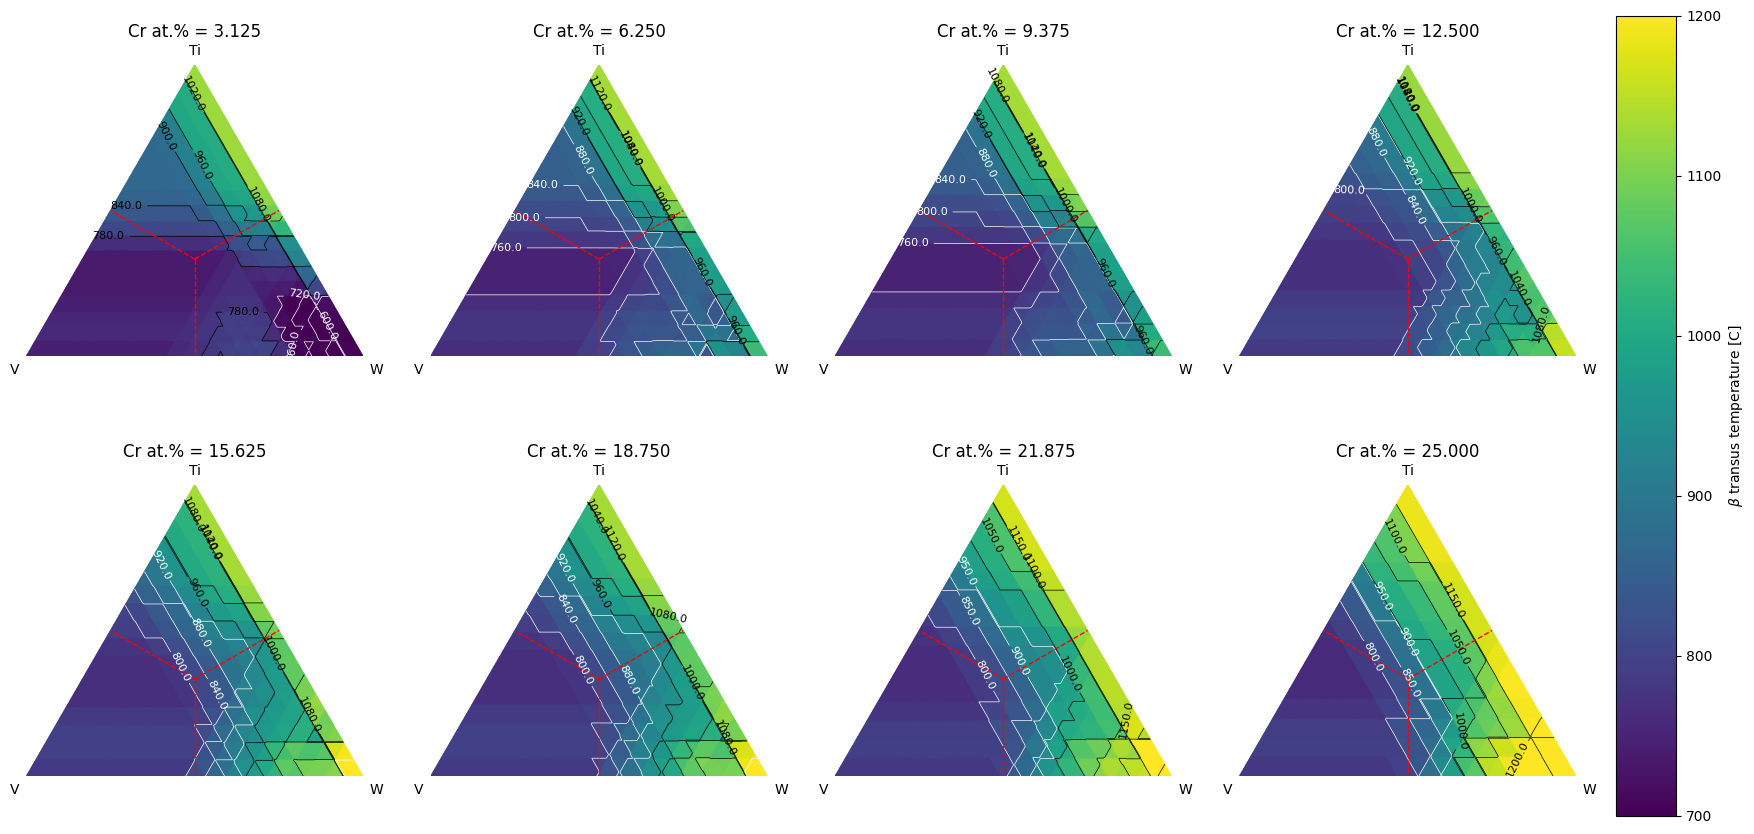

In [116]:
# Create the figure
fig = plt.figure(figsize=(12, 12))

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

heatmaps=[]

# `axes` is an array of shape (2, 4), where each element is an AxesSubplot object
for i, ax in enumerate(axes.flatten()):
    Cr_fraction = (i+1)*0.25/8
    if(1==1):
        heatmaps.append(plot_ternary_heatmap(ax,'V','W','Ti','Cr',Cr_fraction))
        ax.set_title('Cr at.% = {:0.3f}'.format(Cr_fraction*100), pad=20)  # Set a title for each subplot

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.03, 0.8])  # Adjust these values for your layout
fig.colorbar(heatmaps[1], cax=cbar_ax, label=label)